# 单因子回测流程
基于Fama-MacBeth回归
---
1. 数据获取
2. 数据清洗
3. 选取时间窗口 --> 获取beta（因子暴露度）预估值
4. 在每个截面上进行回归 --> 获取因子收益率预估值
5. 计算因子收益率的期望值，收益率的期望值

数据获取，以上证50成分股数据为研究基础，构建简单市场因子CAPM
数据来源：tushare

In [1]:
from data_get import tushare_pro
from calculation import Regression
from utils import matplotlib_ch_font
import tushare as ts
import pandas as pd

pro = ts.pro_api('8048cbf9b5b32cf6c5ca12b8863a1869901b566749dccbd796b458b5')
my_ts = tushare_pro.TushareData()

matplotlib_ch_font.matplot_ch_font()

In [2]:
t_window = 252
t_prediction = 30
t_prediction_2 = 60
t_prediction_3 = 90

T_start = pd.to_datetime('2015-12-31').date()
T_end = pd.to_datetime('2021-12-31').date()

## 获取指数数据

<AxesSubplot:xlabel='trade_date'>

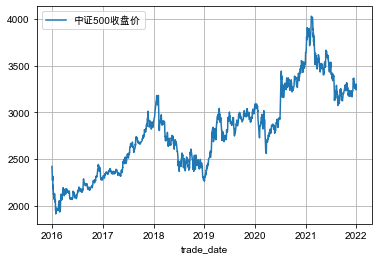

In [3]:
# tushare 获取数据
index_data = my_ts.daily_index(ts_code='000016.sh')

# 选取列
index_data = index_data.loc[:, ['trade_date', 'close']]

# 日期格式
index_data['trade_date'] = pd.to_datetime(index_data['trade_date']).dt.date
index_data.sort_values(by='trade_date', inplace=True)

# 选取回测区间数据
index_data = index_data.loc[(index_data['trade_date'] >= T_start) & (index_data['trade_date'] <= T_end)]

# 重设index
index_data.reset_index(inplace=True, drop=True)
index_data.rename(columns={'close': '中证500收盘价'}, inplace=True)
index_data.plot(kind='line', x='trade_date', y='中证500收盘价', grid='both')

# 获取股票数据及处理

In [4]:
# 股票列表
stock_list = pro.index_weight(**{
    "index_code": "000016.sh",
    "trade_date": 20220729,
    "start_date": "",
    "end_date": "",
    "limit": "",
    "offset": ""
}, fields=[
    "con_code",
    "weight"
])

In [43]:
# 获取股票行情数据
stock_data = list(map(my_ts.daily_bar, stock_list['con_code']))
stock_data = pd.concat(stock_data, axis=0)
stock_data = stock_data[['ts_code', 'trade_date', 'close']]
# 日期格式
stock_data['trade_date'] = pd.to_datetime(stock_data['trade_date']).dt.date
stock_data.sort_values(by='trade_date', inplace=True)

# 选取回测区间数据
stock_data = stock_data.loc[(stock_data['trade_date'] >= T_start) & (stock_data['trade_date'] <= T_end)]

# 重设index
stock_data.reset_index(inplace=True, drop=True)
stock_data

,ts_code,trade_date,close
0,600893.SH,2015-12-31,45.03
1,600031.SH,2015-12-31,6.58
2,603288.SH,2015-12-31,35.35
3,601668.SH,2015-12-31,6.34
4,600104.SH,2015-12-31,21.22
...,...,...,...
66349,600436.SH,2021-12-31,437.15
66350,600196.SH,2021-12-31,48.94
66351,601398.SH,2021-12-31,4.63
66352,600346.SH,2021-12-31,22.97


## 增加drifts列，回归函数

<AxesSubplot:ylabel='Frequency'>

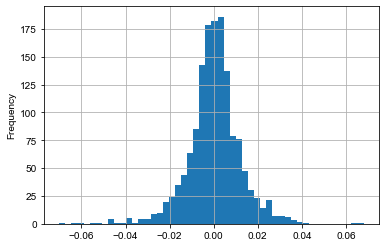

In [6]:
index_data['drifts'] = index_data['中证500收盘价'] / index_data['中证500收盘价'].shift(1) - 1
index_data['drifts'].plot(kind='hist', bins=50, grid='both')

In [ ]:
index_data.set_index('trade_date', inplace=True)
index_data

In [ ]:
# 增加股票drifts列
stock_data.set_index(['trade_date', 'ts_code'], inplace=True)
stock_data

In [ ]:
from datetime import date
# stock_data.loc[date(2015, 12, 31)]
# stock_data['2015-12-31']
stock_data.loc[stock_data.index.get_level_values(0)]

In [ ]:
stock_data.index.get_level_values(0)

In [ ]:
def add_drifts_factors(stock_code):

    # add drifts
    current_stock_data =  stock_data.loc[stock_data['ts_code'] == stock_code].copy()
    current_stock_data['drifts'] = current_stock_data['close'] / current_stock_data['close'].shift(1) - 1

    # add factor
    def add_factor(rolling_data):
        trade_date = list(rolling_data['trade_date'])
        result = Regression.OLS(rolling_data, index_data.loc[index_data['trade_date'].isin(trade_date)])
        return result.params[0], result.params[1]

    current_stock_data['alpha'], current_stock_data['beta'] \
        = current_stock_data['drifts'].rolling(240).apply(lambda x: add_factor(x))

    return current_stock_data

In [ ]:
def add_factor(rolling_data):
    a = list(rolling_data['trade_date'])
    return index_data.loc[index_data['trade_date'].isin(a)]
    # result = Regression.OLS(rolling_data['drifts'], index_data.loc[index_data['trade_date'].isin(a)])
    # return result.params[0]

test['alpha'] = test.rolling(240).apply(lambda x: add_factor(x))

In [ ]:
test =  stock_data.loc[stock_data['ts_code'] == '600585.SH'].copy()
test['drifts'] = test['close'] / test['close'].shift(1) - 1
test

In [31]:
def add_drifts_factors(stock_code):

    # add drifts
    current_stock_data =  stock_data.loc[stock_data['ts_code'] == stock_code].copy()
    current_stock_data['drifts'] = current_stock_data['close'] / current_stock_data['close'].shift(1) - 1

    # add factor
    def add_factor(rolling_data):
        trade_date = list(rolling_data['trade_date'])
        result = Regression.OLS(rolling_data, index_data.loc[index_data['trade_date'].isin(trade_date)])
        return result.params[0], result.params[1]

    current_stock_data['alpha'], current_stock_data['beta'] \
        = current_stock_data['drifts'].rolling(240).apply(lambda x: add_factor(x))

    return current_stock_data

In [11]:
def add_factor(rolling_data):
    a = list(rolling_data['trade_date'])
    return index_data.loc[index_data['trade_date'].isin(a)]
    # result = Regression.OLS(rolling_data['drifts'], index_data.loc[index_data['trade_date'].isin(a)])
    # return result.params[0]

test['alpha'] = test.rolling(240).apply(lambda x: add_factor(x))

KeyError: 'trade_date'

In [9]:
test =  stock_data.loc[stock_data['ts_code'] == '600585.SH'].copy()
test['drifts'] = test['close'] / test['close'].shift(1) - 1
test

,ts_code,trade_date,close,drifts
38,600585.SH,2015-12-31,17.10,NaN
45,600585.SH,2016-01-04,16.07,-0.060234
112,600585.SH,2016-01-05,16.09,0.001245
166,600585.SH,2016-01-06,16.68,0.036669
191,600585.SH,2016-01-07,15.52,-0.069544
...,...,...,...,...
66137,600585.SH,2021-12-27,41.49,-0.006941
66189,600585.SH,2021-12-28,40.89,-0.014461
66207,600585.SH,2021-12-29,40.47,-0.010271
66274,600585.SH,2021-12-30,40.45,-0.000494
